<a href="https://colab.research.google.com/github/gregor-posadas/Gregor-Projects/blob/main/mod03_1D_Diffusion_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 03: Assignment for 1-D Diffusion Problem - Thawing Permafrost

### 1. Introduction and Background

In this notebook you are going to investigate the impact of three climate change scenarios on our previously developed model of the vertical distribution of temperature in a permafrost soil.


Again, the equation for 1-dimensional heat diffusion into a soil is presented below:
$$
\rho_s \cdot C_s \cdot \frac{\partial T_s}{\partial t} = \frac{\partial T_s}{\partial z}\left(k_s \cdot \frac{\partial T_s}{\partial z}\right)
$$

where $\rho_s$ (kg/m^3) is the bulk density of the soil, $C_s$ (J/(kg K)) is the heat capacity of the soil, $k_s$ (W/(m K)) is the thermal conductivity of the soil, $T_s$ is the temperature of the soil at some time $t$ and depth in the soil $z$. For the sake of simplicity, we're going to assume that the thermal conductivity is constant. This assumption is not strictly true, as $k_s$ changes with the amount and phase (frozen or liquid) of water in the soil. But it makes the math much simpler and is good starting point for a toy model. Under this assumption we can simplify the above equation to,

$$
\rho_s \cdot C_s \cdot \frac{\partial T_s}{\partial t} = k_s \frac{\partial T_s^2}{\partial^2 z}
$$

Going further, if we also assume that the bulk density ($rho_s$) and heat capacity ($C_s$) are constant, then we can combine them with the thermal conductivity and reduce them to a single parameter that is often referred to as the _thermal diffusivity_ ($D_s$) and has dimensions of m^2/s,

$$
D_s = \frac{k_s}{\rho_s \cdot C_s}
$$

Substituting into the above, we obtain the following governing equation that our model will solve,

$$
\frac{\partial T_s}{\partial t} = D_s \frac{\partial T_s^2}{\partial^2 z}
$$

Your __top boundary condition__, we will assume sinusoidal forcing of air temperature superimposed on a linear trend in mean annual temperatures at the surface, with a period of one year. In this notebook we will explore three scenarios. Scenario 1 is a linear increase in mean annual temperature at a rate that results in 1.5 °C of warming by 2100. Scenario 2 is a linear increase in mean annual temperature at a rate that results in 3.0 °C of warming by 2100. Scenario 3 is a linear increase in mean annual temperature at a rate that results in 4.5 °C of warming by 2100. We will start all simulations in 2020.

Your __bottom boundary condition__, we will assume a constant temperature at the initial mean annual air temperature.

Yur __initial condition__ will be a constant temperature (isothermal) at the mean annual air temperature. If interested you can copy this notebook and modify these values.

### 2. Initial Setup

Below, we set the values for our spatial domain, simulation period, soil properties, and boundary conditions.

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Soil column properties
zs = 500.0 # Depth of soil [cm]
dz = 15.0   # Numerical model layer thickness [cm]

# Soil properties (obtained from https://doi.org/10.1029/2017JF004535)
Cs = 635.0 # Heat capacity of soil/permafrost [J/(kg K)]
ks = 0.25  # Thermal conductivity of soil/permafrost [W/(m K)]
rhos = 920.0 # Bulk density of permafrost [kg/m^3]

dt = 0.25 # Time step [day]

#### 2.1 Load and Plot the Air Temperature Trends

In [31]:
data = np.loadtxt('PermafrostTemperatureScenarios.csv', delimiter=',', skiprows=1)

t_year = data[:,0]
T_15 = data[:,1]
T_30 = data[:,2]
T_45 = data[:,3]

Text(0, 0.5, 'Annual average air temperature [°C]')

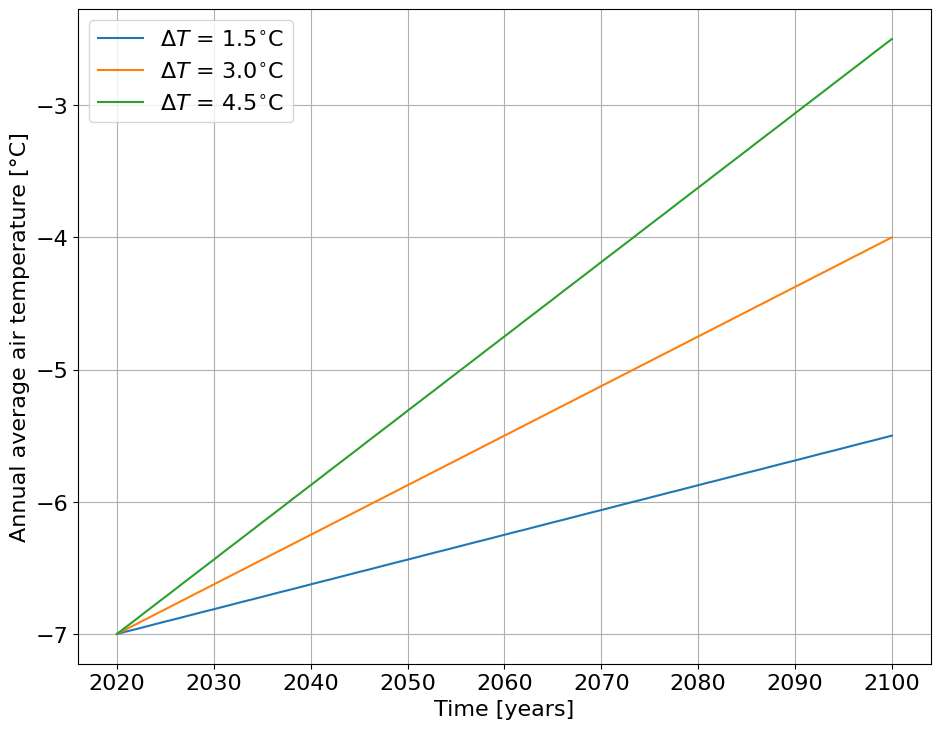

In [32]:
## First off, let's change the font size for all of our plots to be more legible
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(11.0,8.5))
plt.plot(t_year,T_15,label='$\Delta T$ = 1.5${}^{\circ}$C')
plt.plot(t_year,T_30,label='$\Delta T$ = 3.0${}^{\circ}$C')
plt.plot(t_year,T_45,label='$\Delta T$ = 4.5${}^{\circ}$C')
plt.legend(loc='upper left')
plt.grid()
plt.xlabel('Time [years]')
plt.ylabel('Annual average air temperature [°C]')

#### 2.2 Setup the Simulation Time Period

In [33]:
# Time properties of simulation
t0 = t_year[0]
tf = t_year[-1]

t = np.arange(t0,tf+(dt/365),(dt/365))
Nt = t.size
print('The number of time steps: Nt = ',str(Nt))

The number of time steps: Nt =  116801


### 3. Setup Boundary Conditions

In [34]:
# Boundary conditions
Ttopamp = 35.0
Tbottom = -7.0

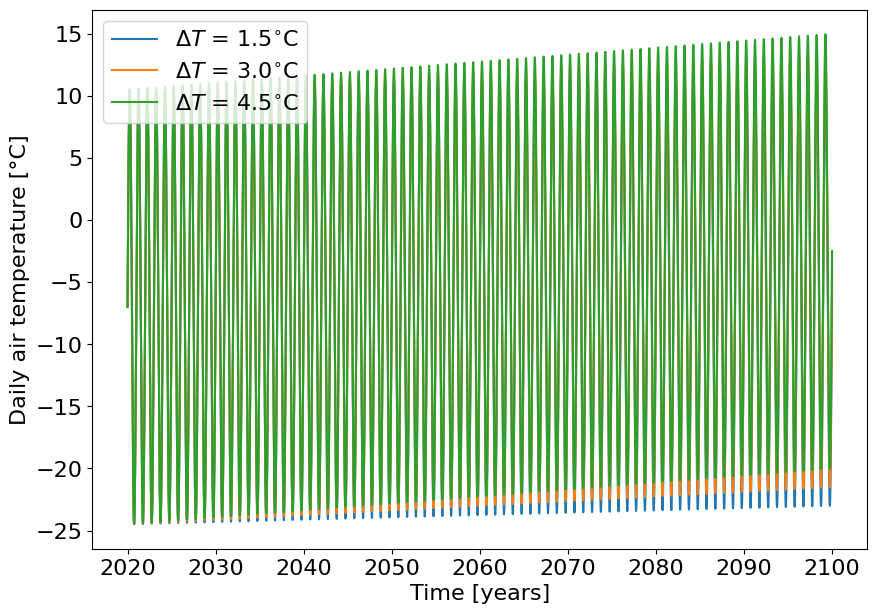

In [35]:
Ttop_15 = np.interp(t, t_year, T_15) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)
Ttop_30 = np.interp(t, t_year, T_30) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)
Ttop_45 = np.interp(t, t_year, T_45) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)

plt.figure(figsize=(10.0,7.0))
plt.plot(t, Ttop_15, label='$\Delta T$ = 1.5${}^{\circ}$C')
plt.plot(t, Ttop_30, label='$\Delta T$ = 3.0${}^{\circ}$C')
plt.plot(t, Ttop_45, label='$\Delta T$ = 4.5${}^{\circ}$C')
plt.xlabel('Time [years]')
plt.ylabel('Daily air temperature [°C]')
plt.legend(loc='upper left')
plt.show()

### 4. Setup Spatial Domain

In [36]:
# Spatial domain setup
z = np.arange(0, zs + dz, dz)  # Depth levels from 0 to zs, in increments of dz
Nz = z.size  # Number of layers

### 5. Setup Initial Condition

In [52]:
T0 = np.zeros(Nz)           # Preallocates an array of zeros for temperature values
T0[:] = Tbottom             # Replaces all values with Tbottom


### 6. Calculate $D$, $\mathbf{A}$, and $\mathbf{B}$ Matrices for Implicit or Crank-Nicolson Method

*Will try using Crank-Nicolson Method since it was not discussed too much in class.*

In [53]:
# Thermal diffusivity [m^2/s]
Ds = ks / (rhos * Cs) #ks, rhos, and Cs were part of the initial setup

# Crank-Nicolson method setup
alpha = Ds * dt * 86400 / (dz / 100)**2  # Alpha factor (converted time to seconds and dz to meters)

# Initialize A and B matrices
A = np.zeros((Nz, Nz))
B = np.zeros((Nz, Nz))

# Fill the matrices A and B
for i in range(1, Nz - 1):
    A[i, i - 1] = -alpha / 2  # Lower diagonal
    A[i, i] = 1 + alpha       # Main diagonal
    A[i, i + 1] = -alpha / 2  # Upper diagonal

    B[i, i - 1] = alpha / 2   # Lower diagonal
    B[i, i] = 1 - alpha       # Main diagonal
    B[i, i + 1] = alpha / 2   # Upper diagonal

# Boundary conditions: the top and bottom of the matrices
A[0, 0] = 1
A[-1, -1] = 1
B[0, 0] = 1
B[-1, -1] = 1


### 7. Preallocate Storage for Soil Temperatures

In [54]:
# Preallocate storage for the soil temperature matrices (one for each scenario)
Ts_15 = np.zeros((Nz, Nt))  # For ΔT = 1.5°C
Ts_30 = np.zeros((Nz, Nt))  # For ΔT = 3.0°C
Ts_45 = np.zeros((Nz, Nt))  # For ΔT = 4.5°C

### 8. Apply Solution And Compute Temperatures

The equation that must be solved in the Crank Nicolson method is:

A * T^(n+1) = B * T^n

In [59]:
# Set the initial condition (all temperatures at Tbottom)
T0 = np.ones(Nz) * Tbottom  # Initial temperature is constant at the bottom boundary temperature

# Time-stepping loop for each scenario
for scenario, Ttop, Ts in [(Ts_15, Ttop_15, Ts_15), (Ts_30, Ttop_30, Ts_30), (Ts_45, Ttop_45, Ts_45)]:
    # Set the initial temperature profile for time step 0
    Ts[:, 0] = T0

    # Inverse of matrix A
    A_inv = np.linalg.inv(A)

    # Time-stepping loop
    for i in range(1, Nt):
        rhs = B @ Ts[:, i-1]  # Compute the right-hand side using B and the previous time step
        rhs[0] = Ttop[i]      # Apply top boundary condition
        rhs[-1] = Tbottom     # Apply bottom boundary condition

        Ts[:, i] = A_inv @ rhs  # Solve the system of equations

# Now Ts_15, Ts_30, and Ts_45 contain the temperature profiles for the three scenarios over time and depth.

### 9. Plot Results, Analyze, and Interpret

Create plots of the following:

1. A plot of 3 x 2 subplots of the vertical temperature distribution with time. Each row should correspond to each of the 3 climate change scenarios wiht the top row being the $\Delta T$ = 1.5${}^{\circ}$C, the middle being $\Delta T$ = 3.0${}^{\circ}$C, and the bottom row being $\Delta T$ = 4.5${}^{\circ}$C. The left column should correspond to the ___first___ 10 years of simulation, and the right column the ___last___ 10 years of simulation.
2. A plot of 2 x 2 subplots of the temperature at four different levels. One subplot of temperature versus time for all three scenarios at a depth of 50 cm, the second subplot the same information at 100 cm, the third subplot the same information at 200 cm, and the fourth subplot the same information at 400 cm.
3. A markdown table showing the approximate depth of the active layer for each scenario for the first, a middle, and the final decade of the simulation.  

<ipython-input-67-2ad2bb0ef17b>:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space on the right for the color bar


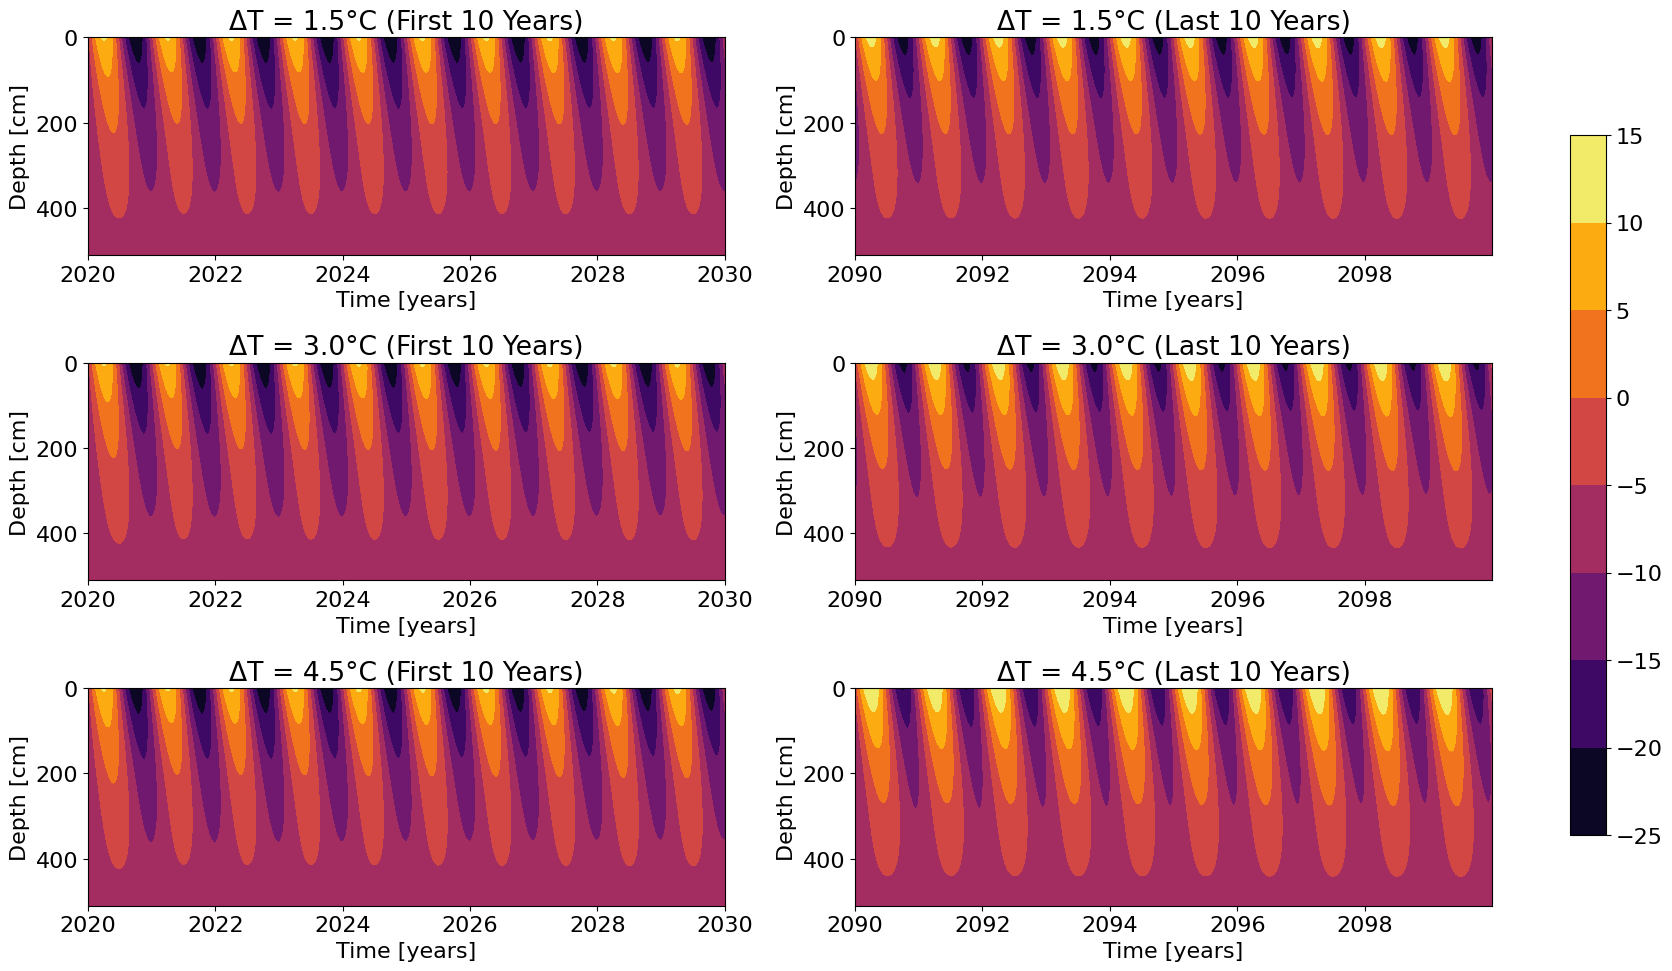

In [67]:
# Time indices for the first and last 10 years
first_10_years = t <= (t[0] + 10)  # First 10 years
last_10_years = t >= (t[-1] - 10)  # Last 10 years

# Set up the figure and axes for the 3x2 subplot grid, with a wider figure size
fig, axes = plt.subplots(3, 2, figsize=(18, 10))  # 18 is the width, 10 is the height
cmap = 'inferno'  # Color map for the plots

# Scenarios: referencing the temperature matrices from Step 8
scenarios = [Ts_15, Ts_30, Ts_45]  # List of temperature data for the three scenarios
titles = ['ΔT = 1.5°C', 'ΔT = 3.0°C', 'ΔT = 4.5°C']  # Titles for each row

# Loop through each row (corresponding to each climate scenario)
for i, Ts in enumerate(scenarios):
    # Plot for the first 10 years (left column)
    c1 = axes[i, 0].contourf(t[first_10_years], z, Ts[:, first_10_years], cmap=cmap)
    axes[i, 0].set_title(f'{titles[i]} (First 10 Years)')
    axes[i, 0].invert_yaxis()  # Depth increases downwards
    axes[i, 0].set_ylabel('Depth [cm]')

    # Plot for the last 10 years (right column)
    c2 = axes[i, 1].contourf(t[last_10_years], z, Ts[:, last_10_years], cmap=cmap)
    axes[i, 1].set_title(f'{titles[i]} (Last 10 Years)')
    axes[i, 1].invert_yaxis()  # Depth increases downwards

# Add a color bar that spans across all plots
fig.subplots_adjust(right=0.85)  # Adjust the space on the right for the color bar
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # Position of the color bar (left, bottom, width, height)
fig.colorbar(c2, cax=cbar_ax)

# Set common labels and format the plot
for ax in axes.flat:
    ax.set_xlabel('Time [years]')
    ax.set_ylabel('Depth [cm]')

# Adjust layout to avoid overlap
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space on the right for the color bar
plt.show()


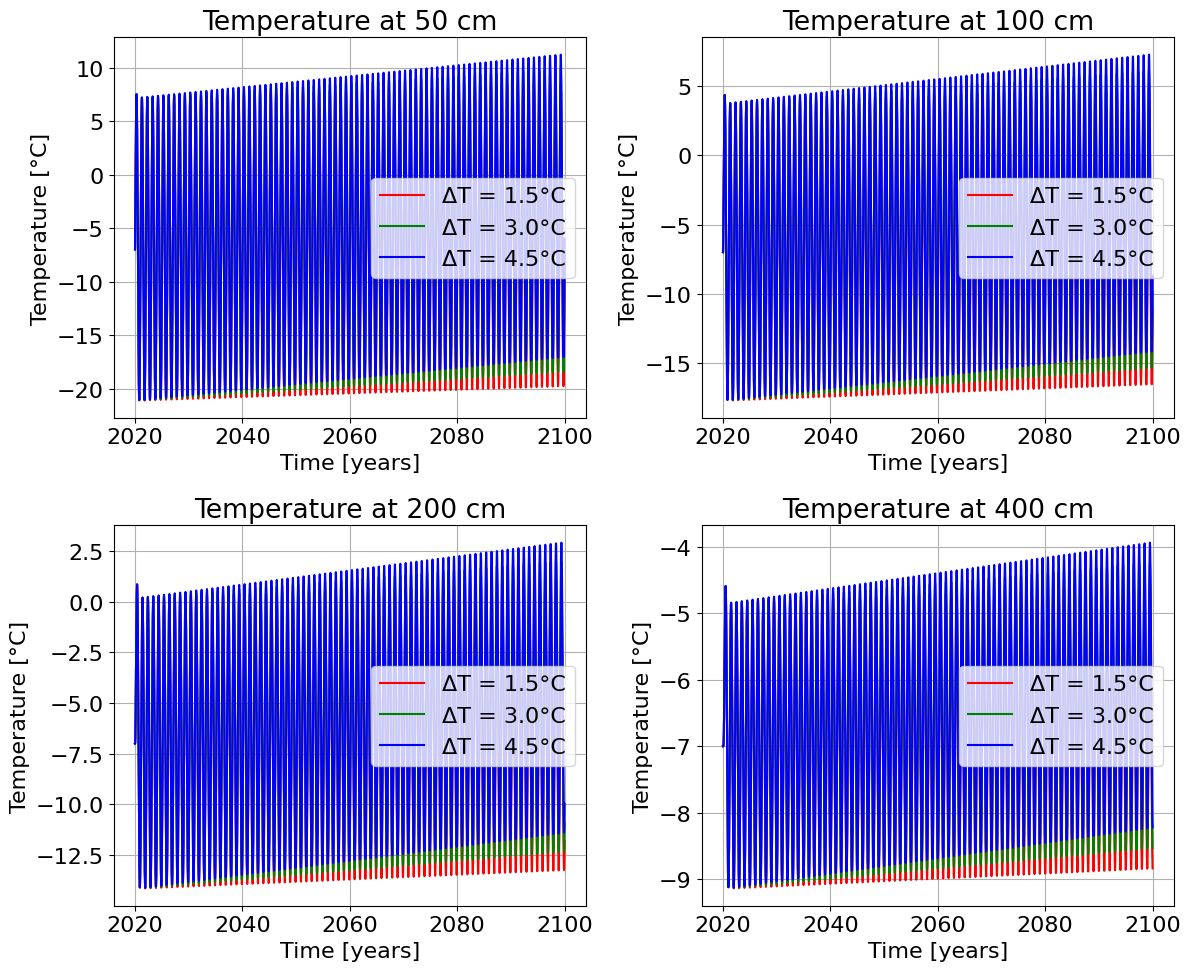

In [68]:
# Define the depths for which we want to plot temperature (in cm)
depths = [50, 100, 200, 400]

# Find the indices in the z array that correspond to the specified depths
depth_indices = [np.abs(z - d).argmin() for d in depths]

# Set up the figure and axes for a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Loop over each subplot and plot the temperature vs time for each depth
for i, ax in enumerate(axes.flat):
    depth_idx = depth_indices[i]  # Get the index for the current depth

    # Plot temperature vs. time for all three scenarios at the current depth
    ax.plot(t, Ts_15[depth_idx, :], label='ΔT = 1.5°C', color='r')
    ax.plot(t, Ts_30[depth_idx, :], label='ΔT = 3.0°C', color='g')
    ax.plot(t, Ts_45[depth_idx, :], label='ΔT = 4.5°C', color='b')

    # Add labels and title
    ax.set_title(f'Temperature at {depths[i]} cm')
    ax.set_xlabel('Time [years]')
    ax.set_ylabel('Temperature [°C]')
    ax.grid(True)
    ax.legend()

# Adjust the layout to avoid overlap
plt.tight_layout()
plt.show()


Based on visual estimates from the plot generated in 9.1
Additionally, the data for the Middle Decade was simply taken as the average between the active layer depths for the first and last decade.

  
| **Decade**       | **ΔT = 1.5°C** | **ΔT = 3.0°C** | **ΔT = 4.5°C** |
|------------------|----------------|----------------|----------------|
| First Decade   | 100 cm         | 120 cm         | 150 cm         |
| Middle Decade    | 100 cm         | 135 cm         | 175 cm         |
| Last Decade      | 100 cm         | 150 cm         | 200 cm         |


